In [1]:
import random
import pandas as pd
import numpy as np
import os
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit, KFold, TimeSeriesSplit
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

train_df = pd.read_csv('./data/train_preprocessed_wsw_0730.csv').drop(columns=['Unnamed: 0'])
test_df =  pd.read_csv('./data/test_preprocessed_wsw_0730.csv').drop(columns=['Unnamed: 0'])

def plot(df):
    # 데이터프레임이 df라고 가정하고, 'power_consumption'이라는 열이 있다고 가정합니다.
    plt.figure(figsize=(100,10))  # 그래프의 크기를 설정합니다.
    #plt.scatter(df.index, df['power_consumption'])  # scatter plot을 그립니다.
    plt.plot(df.index, df['power_consumption'])
    plt.xlabel('Index')  # x축 레이블을 설정합니다.
    plt.ylabel('Power Consumption')  # y축 레이블을 설정합니다.
    plt.title('Scatter plot of Power Consumption')  # 그래프의 제목을 설정합니다.
    plt.show()  # 그래프를 출력합니다.

# custom objective function for forcing model not to underestimate
def weighted_mse(alpha = 1):
    def weighted_mse_fixed(label, pred):
        residual = (label - pred).astype("float")
        grad = np.where(residual>0, -2*alpha*residual, -2*residual)
        hess = np.where(residual>0, 2*alpha, 2.0)
        return grad, hess
    return weighted_mse_fixed

 #점수 측정을 위한 코드
def SMAPE(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

hyperparameters = pd.DataFrame(columns = ['n_estimators', 'eta', 'min_child_weight','max_depth', 'colsample_bytree', 'subsample','alpha','best_it'])

origin_pras = pd.read_csv('./parameters\hyperparameter_xgb_wsw_0730.csv').drop(columns=['Unnamed: 0'])


__________Buildding Number:12 Hyperparameter Tuning__________
_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 5, 'min_child_weight': 8, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.76390097870733
12_____Best Iteration_____ 1288 _____SMAPE Score________ 3.7807187529882373
12_____Best Alpha_____ 75 _____SMAPE Score_____ 3.726491440891371


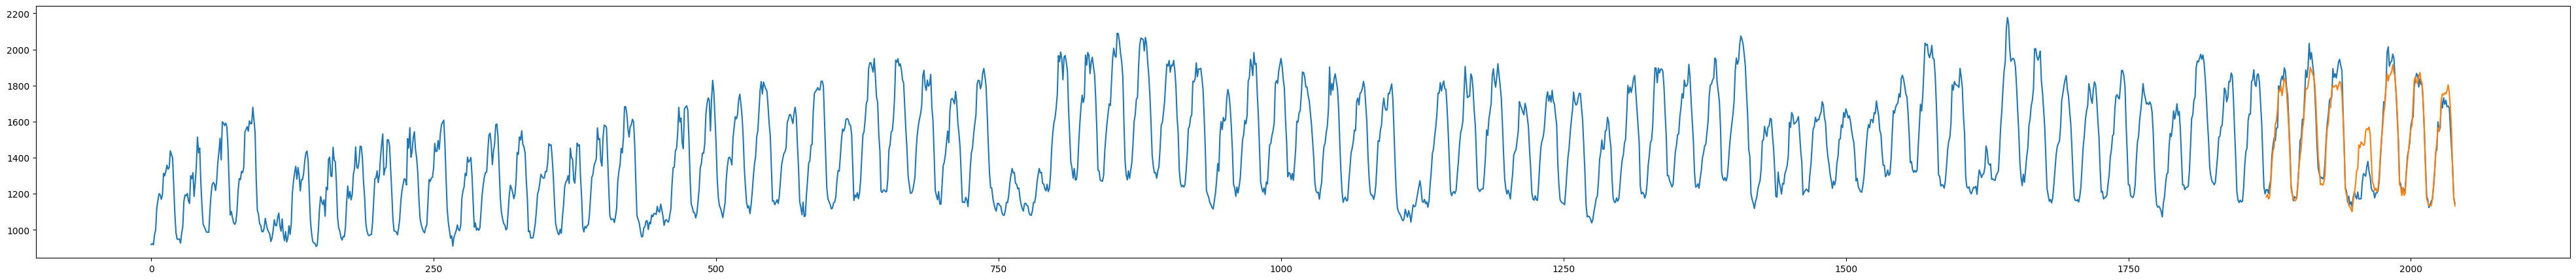

__________Buildding Number:13 Hyperparameter Tuning__________
_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 9, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 45.69173258648628
13_____Best Iteration_____ 643 _____SMAPE Score________ 5.9420267586283835
13_____Best Alpha_____ 100 _____SMAPE Score_____ 5.9420267586283835


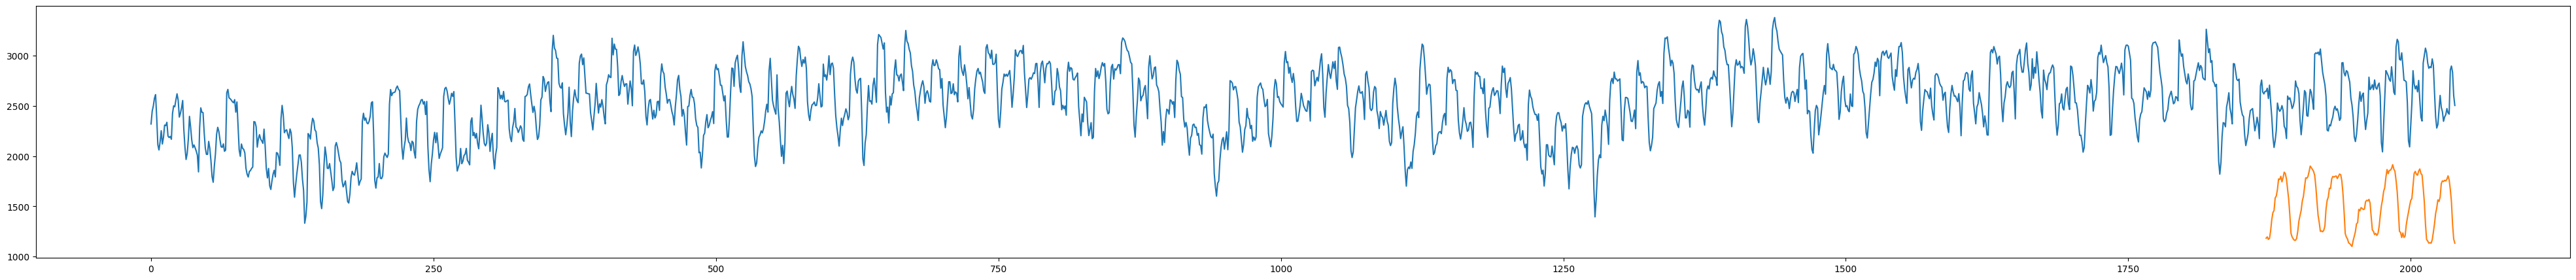

__________Buildding Number:14 Hyperparameter Tuning__________
_____Best Parameters_____ {'colsample_bytree': 0.8, 'eta': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'subsample': 0.8}
_____SMAPE Score________ 39.251616390933094
14_____Best Iteration_____ 218 _____SMAPE Score________ 15.625949202350057
14_____Best Alpha_____ 3 _____SMAPE Score_____ 15.452684327138734


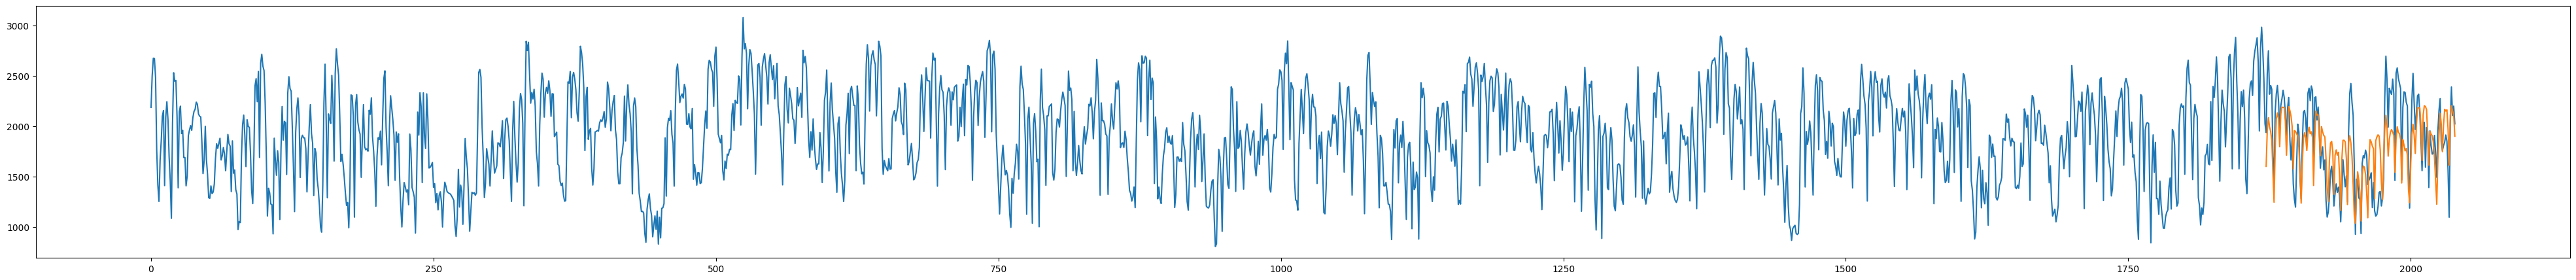

__________Buildding Number:15 Hyperparameter Tuning__________
_____Best Parameters_____ {'colsample_bytree': 0.9, 'eta': 0.01, 'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 100, 'subsample': 0.9}
_____SMAPE Score________ 42.20000308945688
15_____Best Iteration_____ 412 _____SMAPE Score________ 3.0541306138549964
15_____Best Alpha_____ 100 _____SMAPE Score_____ 3.0541306138549964


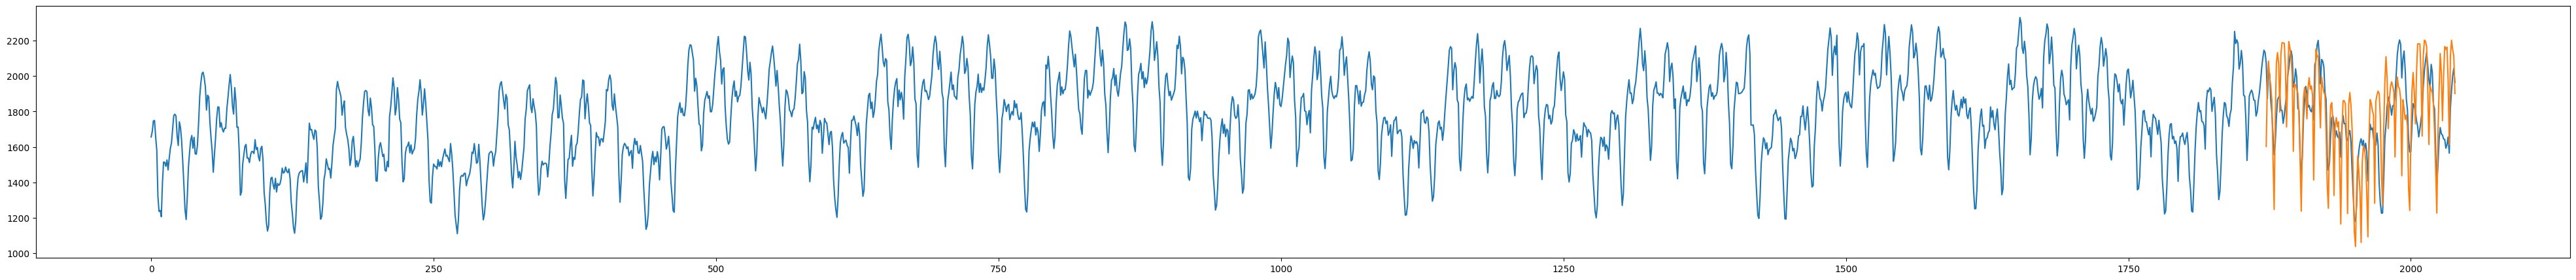

__________Buildding Number:16 Hyperparameter Tuning__________


KeyboardInterrupt: 

In [3]:
#i=12
for i in range(12,24,1):
	#불러오고 나누기
	train_df_1 = train_df.loc[train_df.building_number == i].reset_index()
	train = train_df_1[:-168].drop(columns=['index'])
	vaild = train_df_1[-168:].drop(columns=['index'])
	#하이퍼 파라미터 튜닝 method 1
	#leaf method
	print(f"__________Buildding Number:{i} Hyperparameter Tuning__________")
	preds = np.array([])
	smape_score = make_scorer(SMAPE, greater_is_better=False)
	grid = {'n_estimators' : [100], 'eta' : [0.01], 'min_child_weight' : np.arange(1, 12, 1),
			'max_depth' : np.arange(3,10,1) , 'colsample_bytree' :[0.8, 0.9],
			'subsample' : [0.8, 0.9]} 

	x = train.drop(columns=['power_consumption'])
	y = train['power_consumption']

	#fit
	gcv = GridSearchCV(estimator = XGBRegressor(seed=42,tree_method="hist", gpu_id=0), param_grid=grid, scoring=smape_score, cv=PredefinedSplit(np.append(-np.ones(len(x)-168), np.zeros(168))), refit=True, verbose=False)
	gcv.fit(x, y)

	best = gcv.best_estimator_
	params = gcv.best_params_

	#pred
	x_valid = vaild.drop(columns=['power_consumption'])
	y_valid = vaild['power_consumption']
	pred = best.predict(x_valid)
	print("_____Best Parameters_____",params)
	print("_____SMAPE Score________", SMAPE(y_valid, pred))
	#########################################################################################
	#n_estimators method
	xgb_est = XGBRegressor(tree_method="hist",  gpu_id=0,  seed = 42,
					n_estimators = 10000, eta = 0.01,
					max_depth = params['max_depth'],
					min_child_weight = params['min_child_weight'],
					colsample_bytree = params['colsample_bytree'],
					subsample = params['subsample'])
	xgb_est.set_params(**{'objective':weighted_mse(100)})
	xgb_est.fit(x, y, eval_set=[(x, y),(x_valid, y_valid)], 
			early_stopping_rounds=300, verbose=False)
	it_pred = xgb_est.predict(x_valid)

	best_it= xgb_est.best_iteration
	socre_it = SMAPE(y_valid, it_pred)
	params['best_it'] = best_it+1
	print(f"{i}_____Best Iteration_____", best_it+1,"_____SMAPE Score________", socre_it)
 	#########################################################################################
	#Alpha method
	al_socre = socre_it
	best_alpha = 100

	for j in [1, 3, 5, 7, 10, 25, 50, 75, 100]:
			xgb_al = XGBRegressor(tree_method="hist",  gpu_id=0,  seed = 42,
					n_estimators = params['best_it'], eta = 0.01,
					max_depth = params['max_depth'],
					min_child_weight = params['min_child_weight'],
					colsample_bytree = params['colsample_bytree'],
					subsample = params['subsample'])
			xgb_al.set_params(**{'objective' : weighted_mse(j)})

			xgb_al.fit(x, y)
			al_pred = xgb_al.predict(x_valid)
			score = SMAPE(y_valid, al_pred)
			
			if score < al_socre:
				best_alpha = j
				al_socre = score
				al_best_pred = al_pred
	params['alpha'] = best_alpha
	print(f"{i}_____Best Alpha_____",best_alpha, "_____SMAPE Score_____",al_socre)
	#시각화
	xgb_final = XGBRegressor(tree_method="hist",  gpu_id=0,  seed = 42,
					n_estimators = params['best_it'], eta = 0.01,
					max_depth = params['max_depth'],
					min_child_weight = params['min_child_weight'],
					colsample_bytree = params['colsample_bytree'],
					subsample = params['subsample'])
	xgb_final.set_params(**{'objective' : weighted_mse(params['alpha'])})
	xgb_final.fit(x,y)
	final_pred = xgb_final.predict(x_valid)
	final_score = SMAPE(y_valid, final_pred)
	print(f"{i}_____SMAPE Score_____",final_score)
	y1 = train_df_1['power_consumption']
	y2 = final_pred
	plt.figure(figsize=(50, 5)) 
	plt.plot(np.arange(2040),y1)
	plt.plot(np.arange(2040-168, 2040) ,y2)
	plt.show()
	hyperparameters = pd.concat([hyperparameters, pd.DataFrame(params, index=[i])], axis=0)

In [53]:
y1 = train_df_1['power_consumption']
y1 = y1[-168:]
y2 = al_best_pred
print(SMAPE(y1,y2))

1.416056967189647


In [60]:
y1-y2

1872     6.868115
1873    14.952393
1874    13.205200
1875    16.005054
1876    20.194678
          ...    
2035   -82.178516
2036   -30.949829
2037    -3.967187
2038     3.720605
2039    13.578906
Name: power_consumption, Length: 168, dtype: float64

In [58]:
np.mean(y2)

1293.5881

In [42]:
test = test_df.loc[test_df.building_number == i]

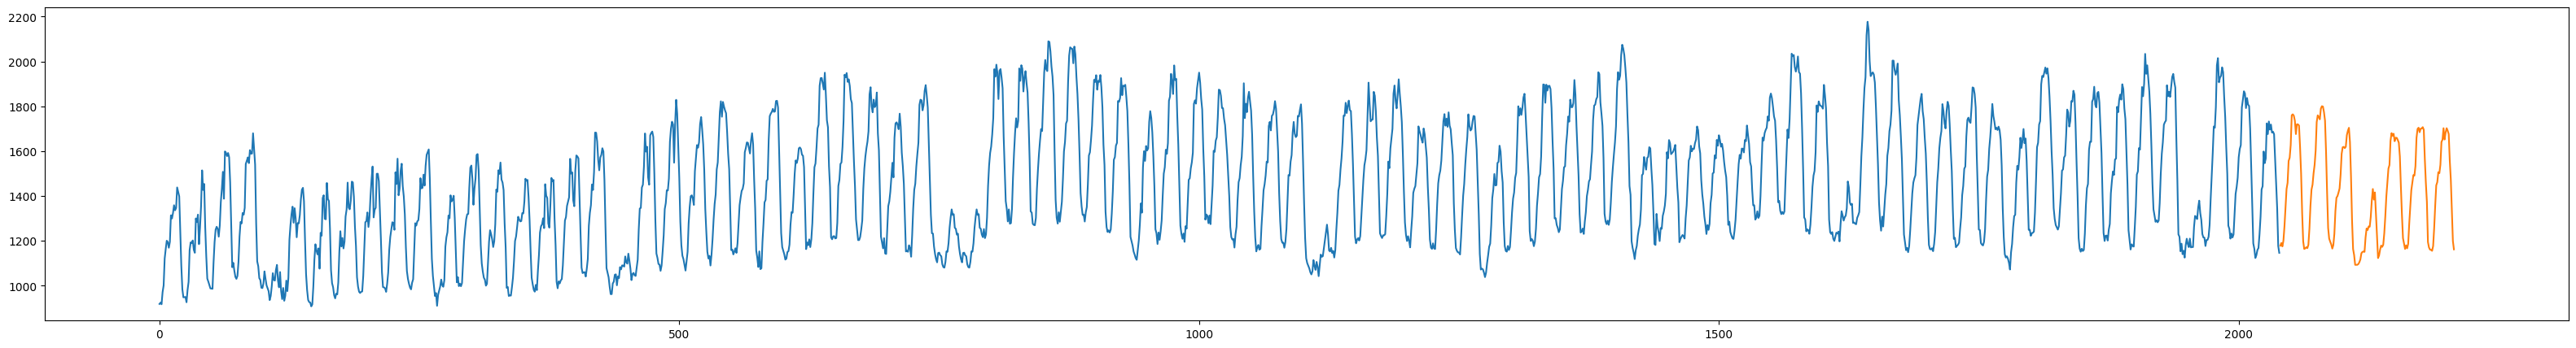

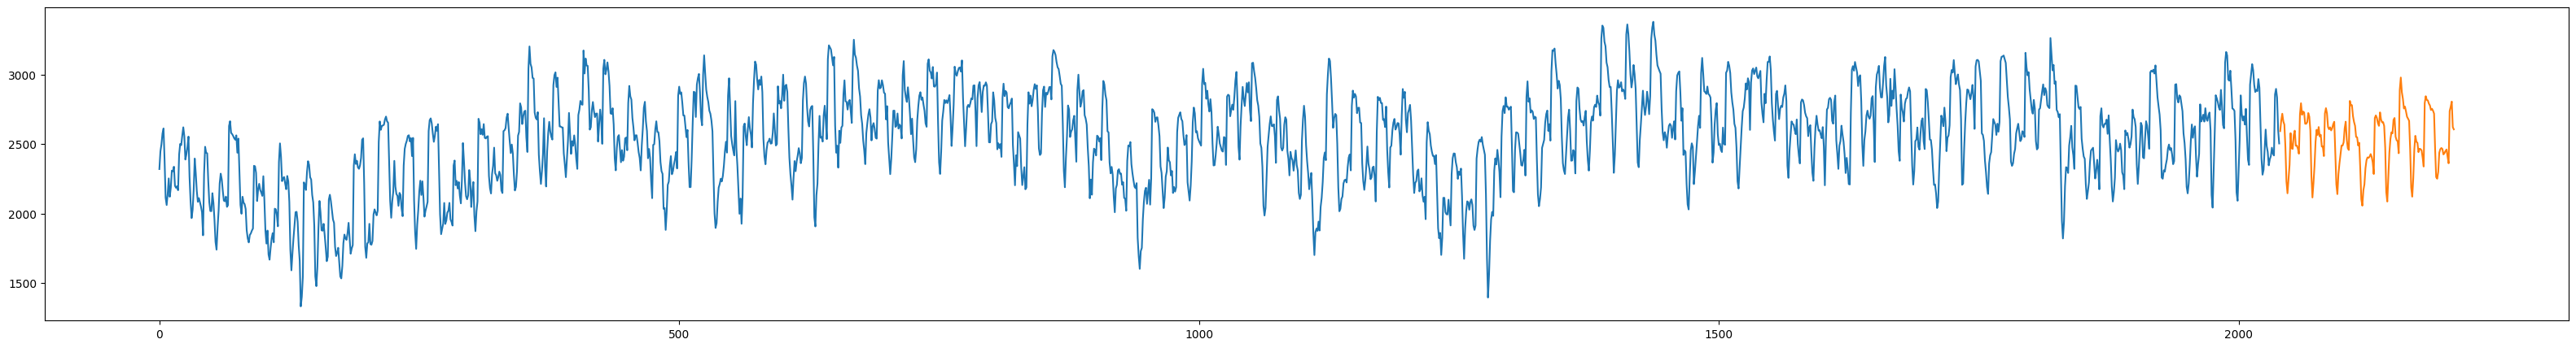

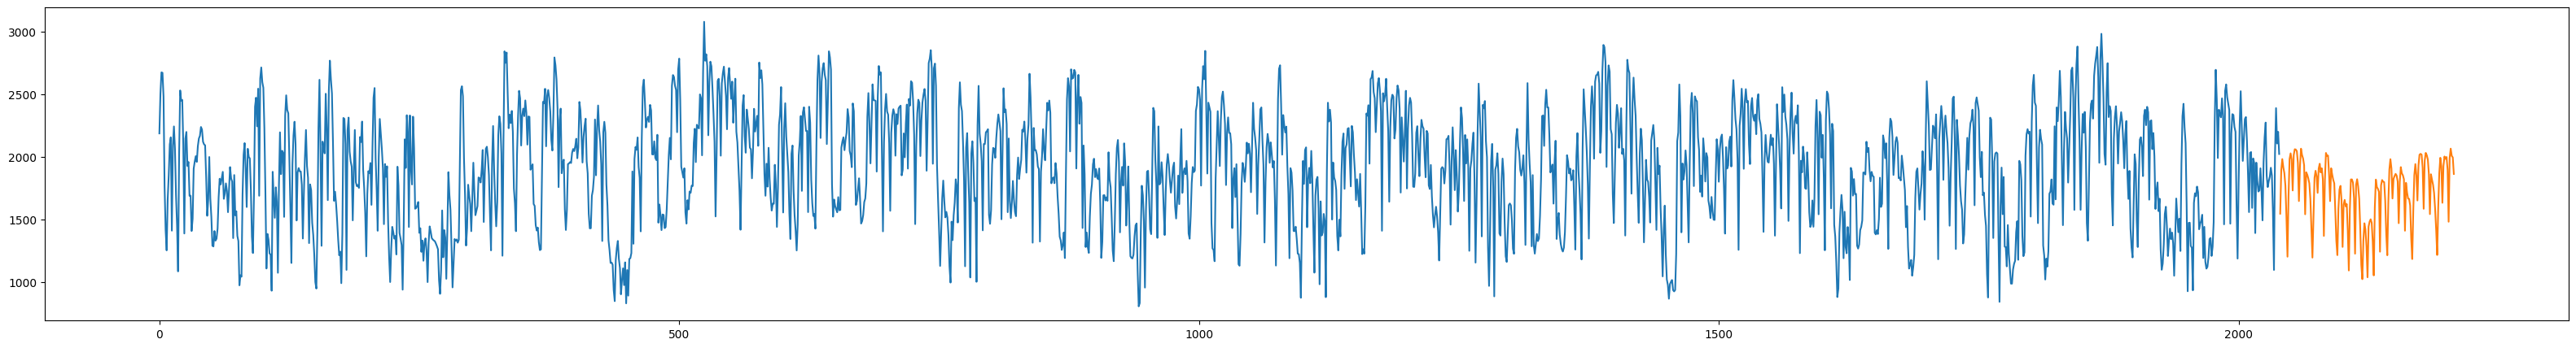

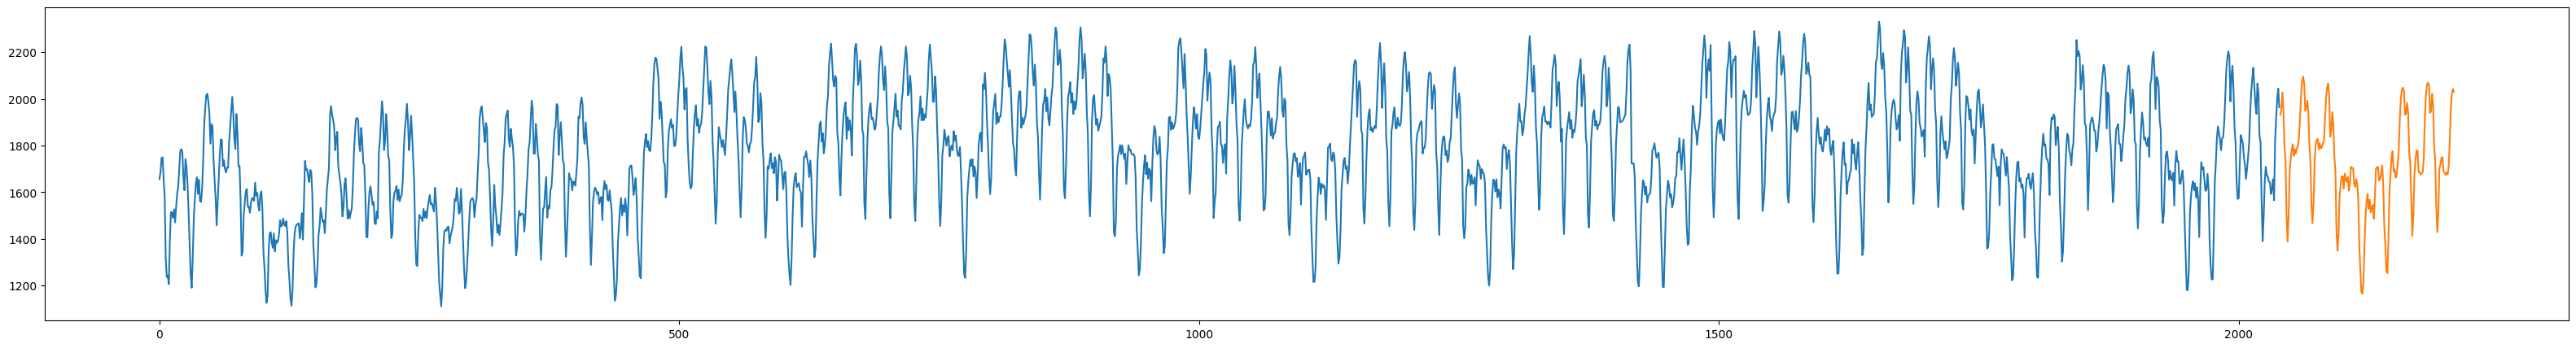

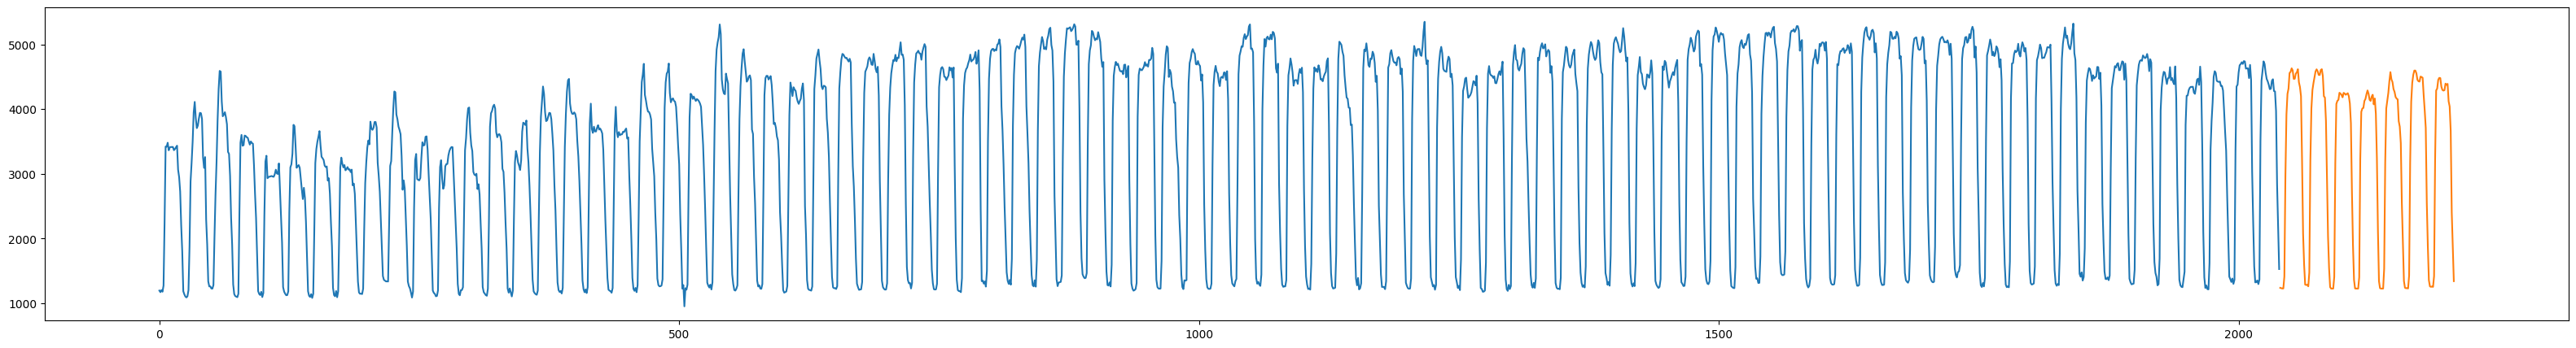

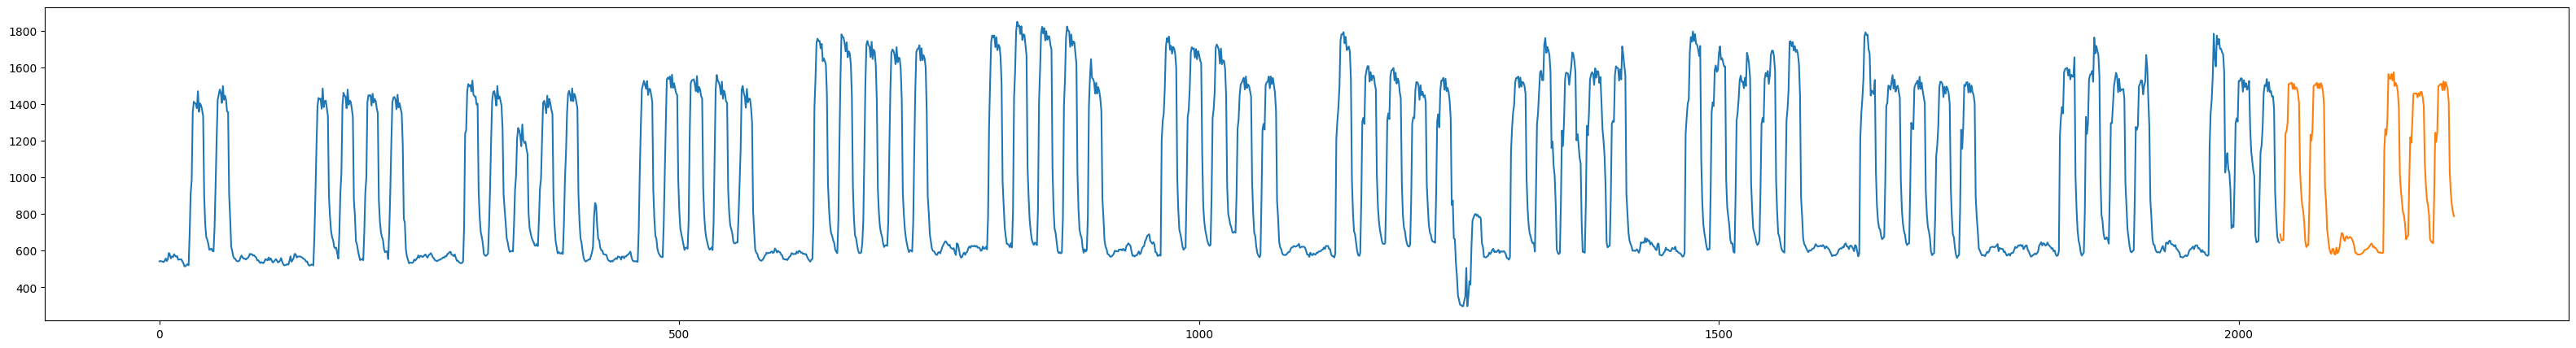

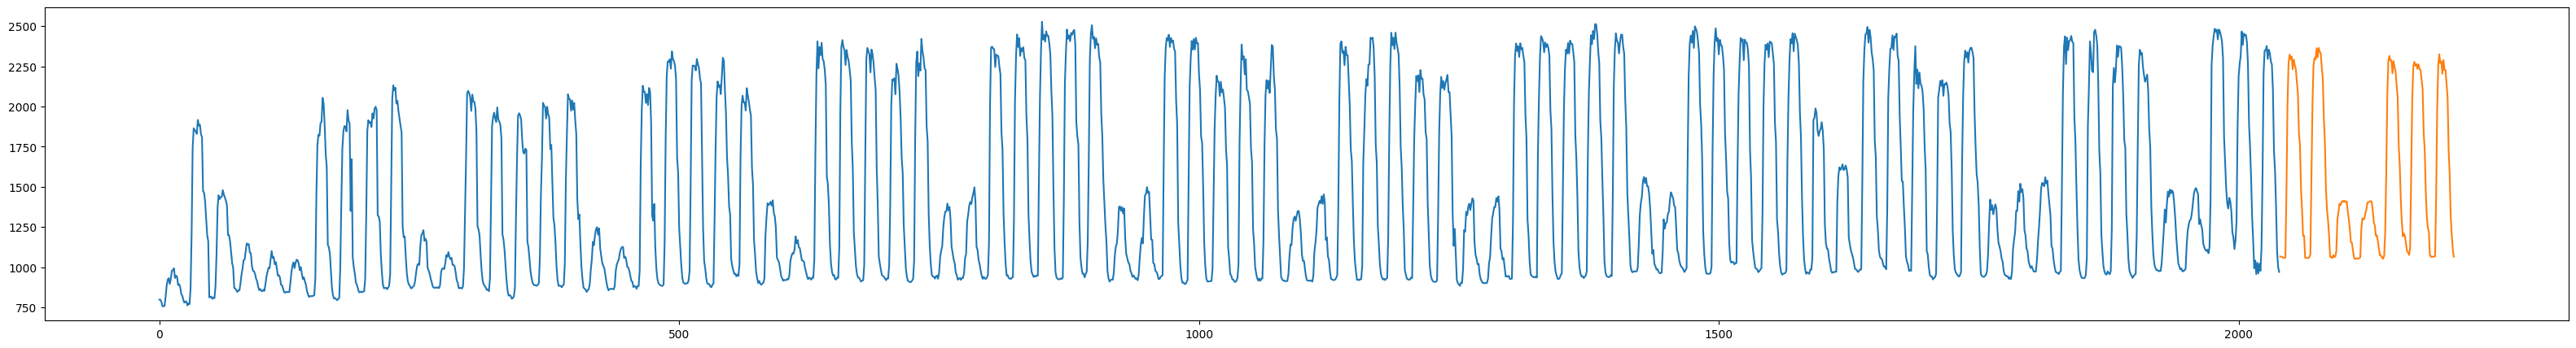

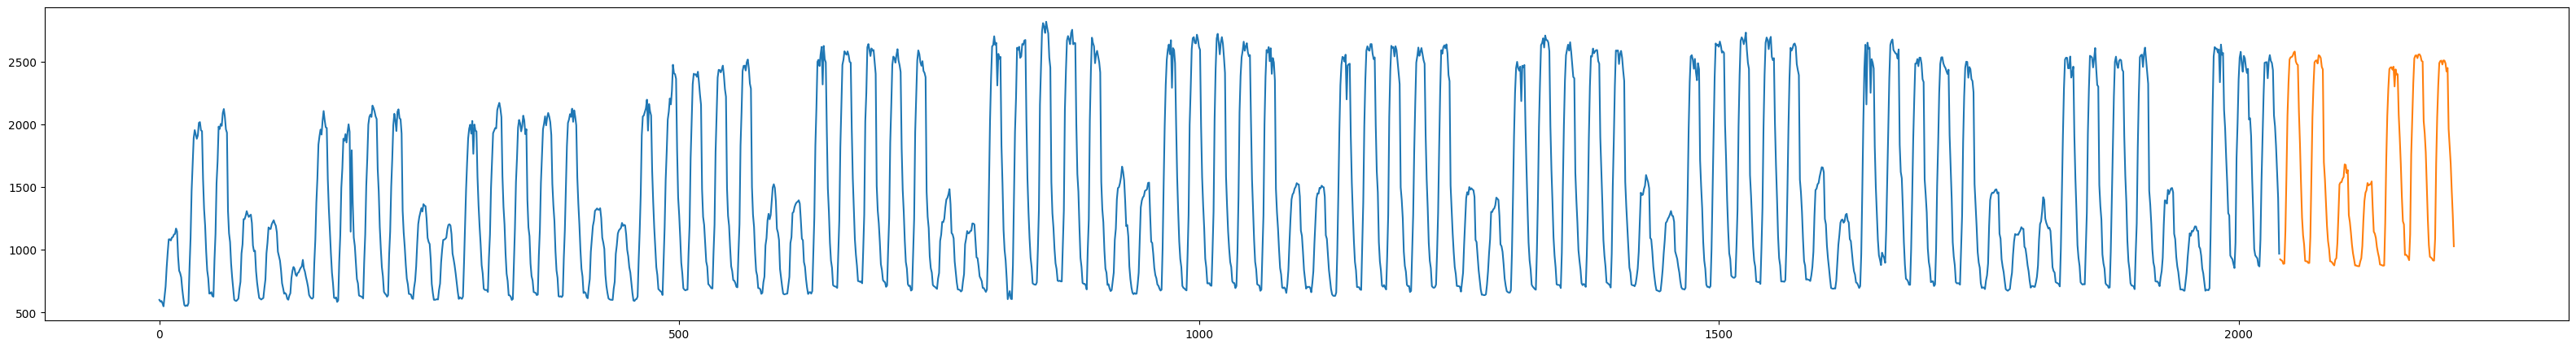

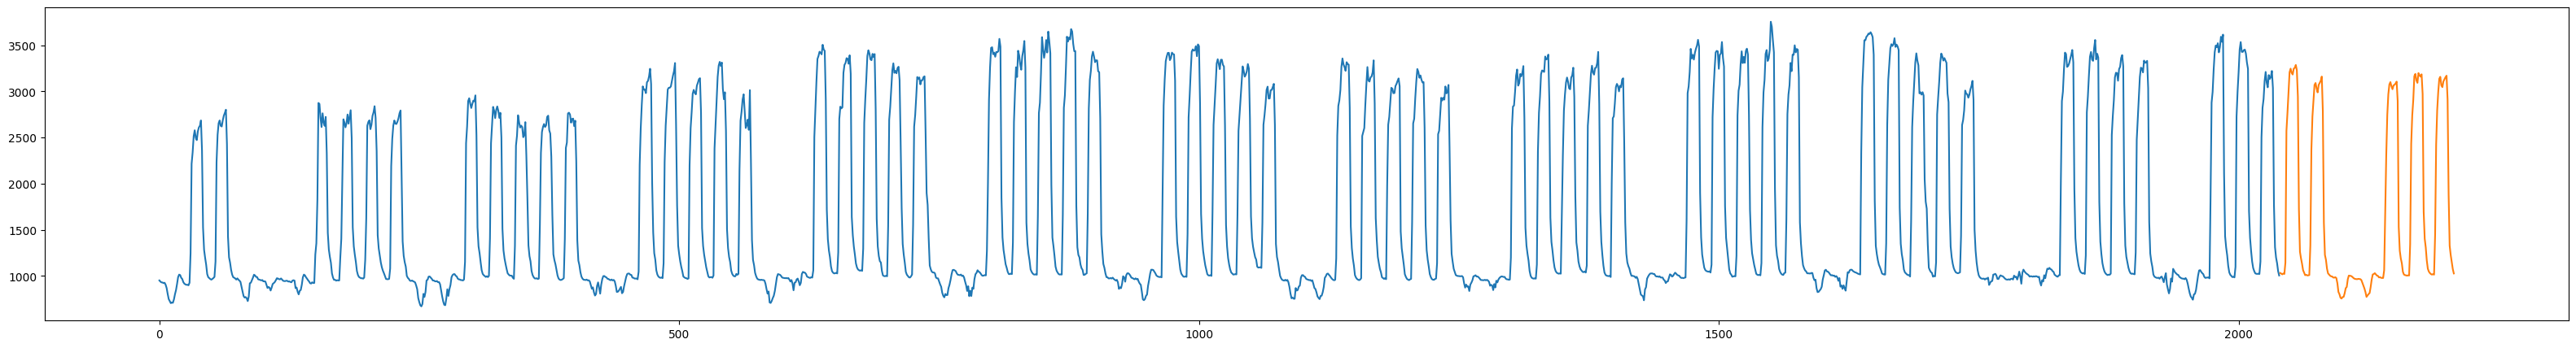

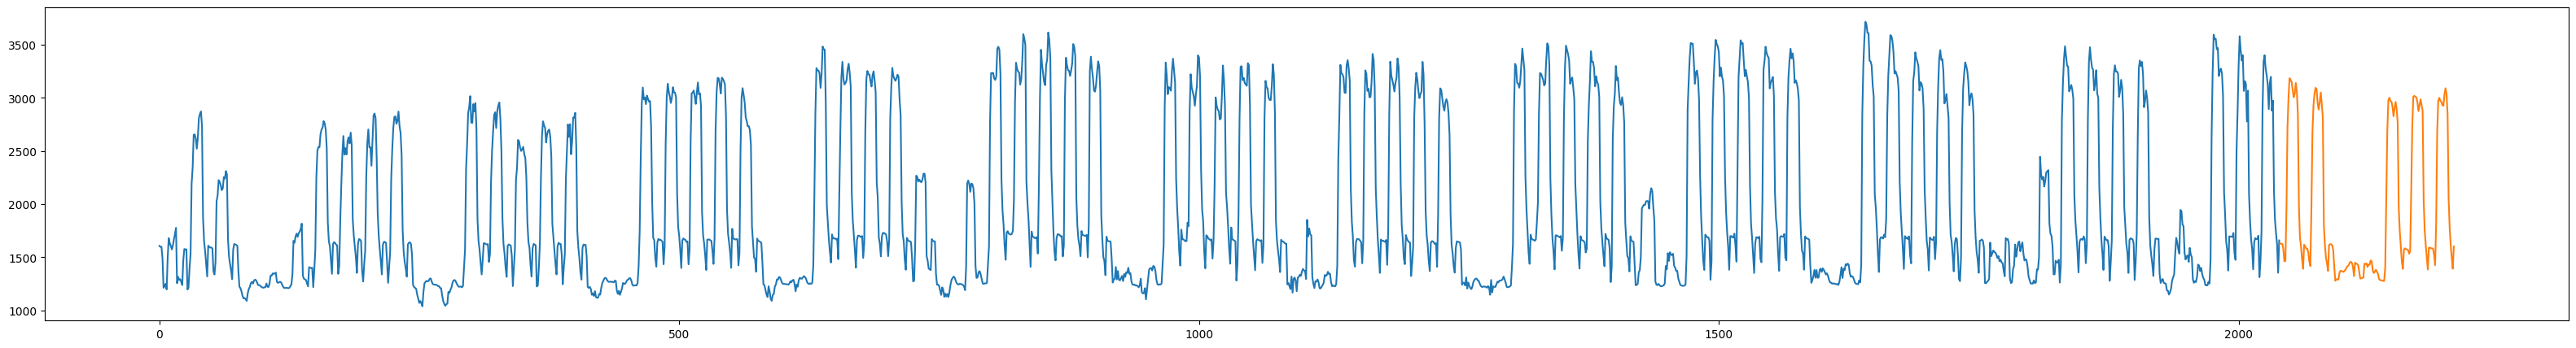

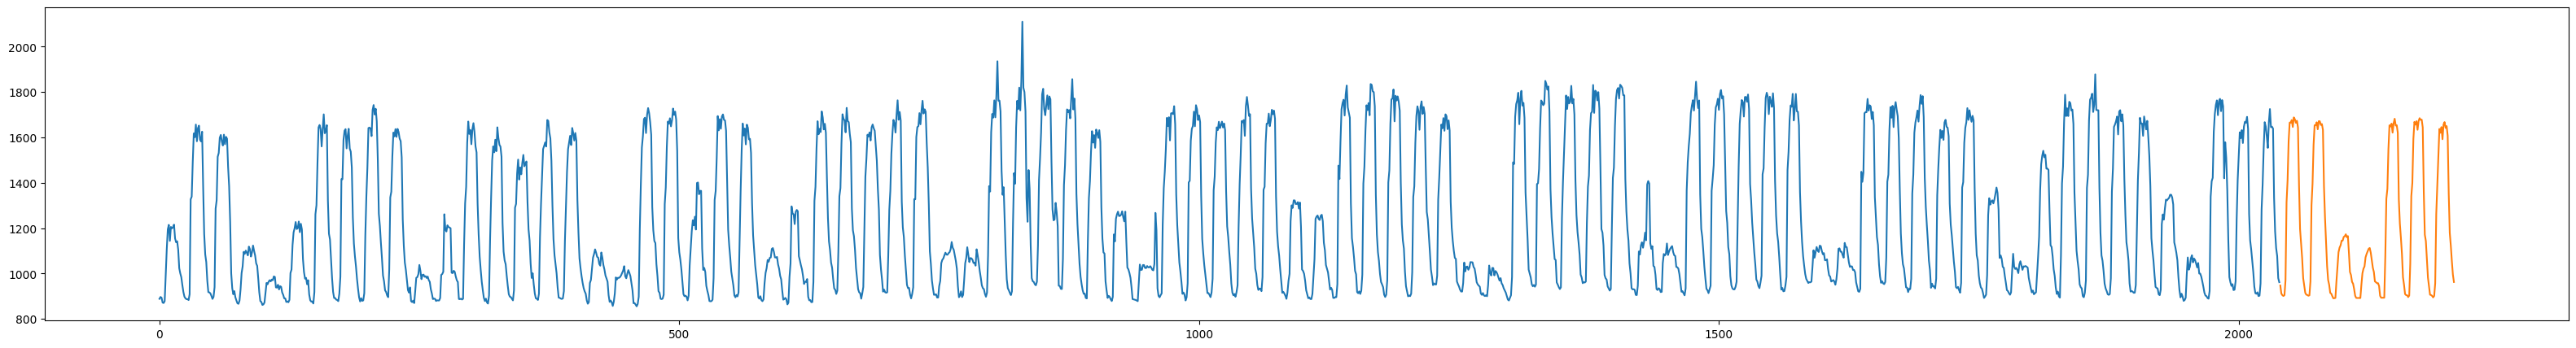

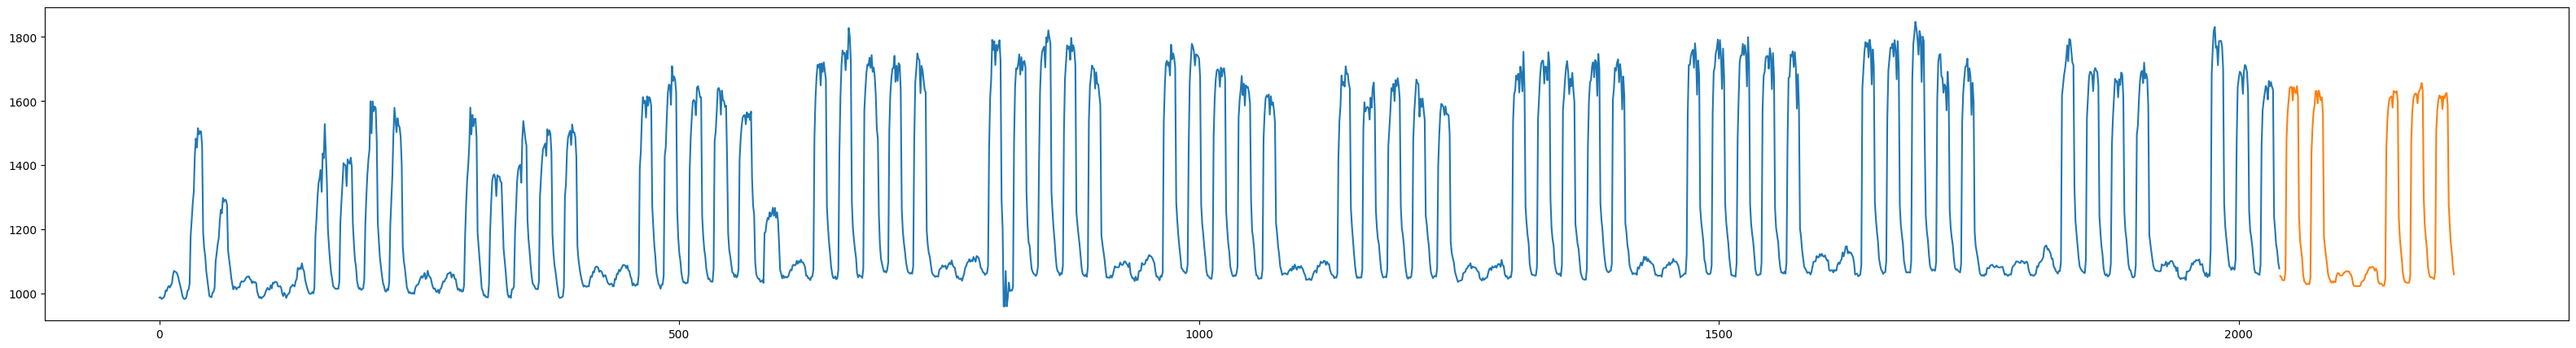

In [48]:
for i in range(12,24,1):
        df = train_df.loc[train_df.building_number == i].reset_index()
        x_df = df.drop(columns=['index','power_consumption'])
        y_df = df['power_consumption']
        test = test_df.loc[test_df.building_number == i].reset_index().drop(columns=['index'])
        
        xgb = XGBRegressor(tree_method="hist",  gpu_id=0,  seed = 42,
                n_estimators = hyperparameters.at[i,'best_it'], eta = 0.01,
                max_depth = hyperparameters.at[i,'max_depth'],
                min_child_weight = hyperparameters.at[i,'best_it'],
                colsample_bytree = hyperparameters.at[i,'colsample_bytree'],
                subsample = hyperparameters.at[i,'subsample'])
        xgb.set_params(**{'objective' : weighted_mse(hyperparameters.at[i,'alpha'])})

        xgb.fit(x_df, y_df)
        pred = xgb.predict(test)
        
        plt.figure(figsize=(40, 5)) 
        plt.plot(np.arange(2040),y_df)
        plt.plot(np.arange(2040, 2040+168) ,pred)
        plt.show()